# AutoEncoder2d Demo

To use this demo, create the conda env defined in ``requirements-dev.conda.yaml``. To demonstrate ``torch_tools.AutoEncoder2d``, we use it to encode and decode MNIST images.

In [1]:
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, RandomRotation
from torchvision.transforms import ColorJitter

from torch.utils.data import DataLoader

batch_size = 8


training_tfms = Compose(
    [
        ToTensor(),
        RandomRotation(180),
        ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    ]
)
valid_tfms = Compose([ToTensor()])


train_set = MNIST(
    root="/home/jim/storage/mnist/",
    train=True,
    download=True,
    transform=training_tfms,
)

print(f"There are {len(train_set)} training items.")
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)

There are 60000 training items.


In this demo, we want bother with a validation loop during training, and will just use the validation set to do some inference at the end. Let's instantiate the model.

In [2]:
from torch.cuda import is_available
from torch_tools import AutoEncoder2d

DEVICE = "cuda" if is_available() else "cpu"

model = AutoEncoder2d(in_chans=1, out_chans=1, num_layers=3, block_style="conv_res",).to(DEVICE)

print(model)

AutoEncoder2d(
  (encoder): Encoder2d(
    (0): ConvResBlock(
      (0): ConvBlock(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (1): ResidualBlock(
        (first_conv): ConvBlock(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.0)
        )
        (second_conv): ConvBlock(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
      )
    )
    (1): DownBlock(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvRe

Now, we set up the optimiser and loss function.

In [3]:
from torch.optim import Adam
from torch.nn import L1Loss

optimiser = Adam(model.parameters(), lr=1e-4)

loss_func = L1Loss()

And now we write our training loop.

In [4]:
from torch.nn import Module


def train_one_epoch(
    model: Module,
    data_loader: DataLoader,
    optimiser: Adam,
    loss_func: L1Loss,
) -> float:
    """Train ``model`` for a single epoch.

    Parameters
    ----------
    model : Module
        AutoEncoder model.
    data_loader : DataLoader
        Training data loader.
    optimiser : Adam
        Adam optimiser.
    loss_func : L1Loss
        The L1 loss function.

    Parameters
    ----------
    float
        Mean loss per item.

    """
    model.train()
    running_loss = 0.0
    for batch, _ in data_loader:
        optimiser.zero_grad()

        batch = batch.to(DEVICE)

        preds = model(batch).tanh()

        loss = loss_func(preds, batch)

        loss.backward()

        optimiser.step()

        running_loss += loss.item()
    return running_loss / len(data_loader)

Now we can train the model.

In [5]:
from time import perf_counter

epochs = 10

metrics = {"loss": []}

for epoch in range(epochs):

    start_time = perf_counter()

    metrics["loss"].append(
        train_one_epoch(
            model,
            train_loader,
            optimiser,
            loss_func,
        )
    )

    stop_time = perf_counter()

    print(f"Epoch {epoch} time: {stop_time - start_time:.6f} seconds")

Epoch 0 time: 40.645411 seconds
Epoch 1 time: 40.128466 seconds
Epoch 2 time: 40.203931 seconds
Epoch 3 time: 39.806797 seconds
Epoch 4 time: 39.876363 seconds
Epoch 5 time: 39.871299 seconds
Epoch 6 time: 39.860227 seconds
Epoch 7 time: 40.074650 seconds
Epoch 8 time: 39.936637 seconds
Epoch 9 time: 40.255790 seconds


Text(0, 0.5, 'Loss')

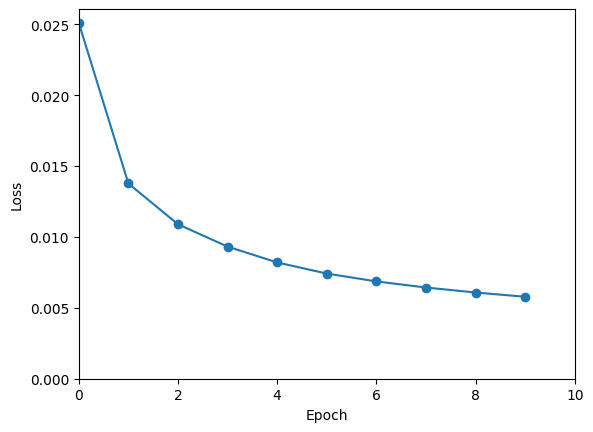

In [6]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 1)
axes.plot(metrics["loss"], "-o")

axes.set_ylim(bottom=0.0)
axes.set_xlim(left=0.0, right=epochs)

axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")

Now we can take a look at some predictions from the validation loader.


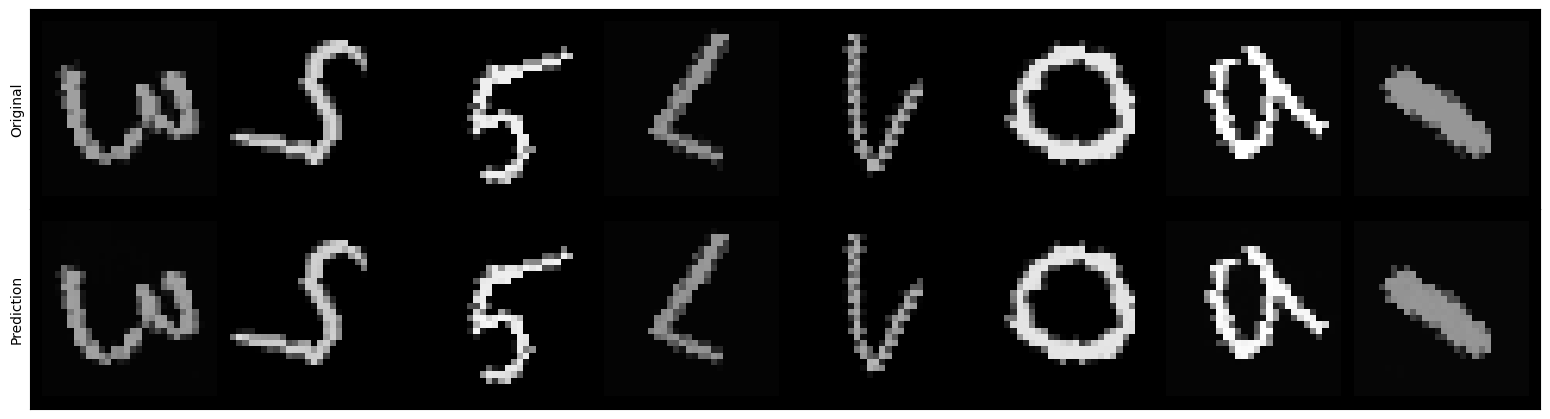

In [7]:
from torch import no_grad
from torchvision.utils import make_grid

with no_grad():
    model.eval()
    for batch, target in train_loader:
        preds = model(batch.to(DEVICE)).tanh().clip(0.0, 1.0)
        break

batch_grid = make_grid(batch.cpu(), nrow=len(batch), ncol=1).permute(1, 2, 0)
pred_grid = make_grid(preds.detach().cpu(), nrow=len(batch), ncol=1).permute(1, 2, 0)


figure, axes = plt.subplots(2, 1, figsize=(len(batch) * 2, 4))
axes[0].imshow(batch_grid)
axes[1].imshow(pred_grid)

for axis in axes.ravel():
    axis.set_xticks([])
    axis.set_yticks([])

axes[0].set_ylabel("Original")
axes[1].set_ylabel("Prediction")

figure.tight_layout(pad=0.01)